In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib as mpl

sys.path.insert(0, '..')
from ccal import plot_heatmap, clean_path, normalize_2d_array, nmf_consensus_cluster_with_multiple_k, make_comparison_panel, compute_information_distance, hierarchical_consensus_cluster_with_multiple_k, normalize_and_plot_heatmap, GPSMap

In [4]:
n_row = 30
n_column = 30

feature_x_sample = pd.DataFrame(
    np.random.random_sample((n_row, n_column)),
    index=('Feature {}'.format(i) for i in range(n_row)),
    columns=('Sample {}'.format(i) for i in range(n_column)))

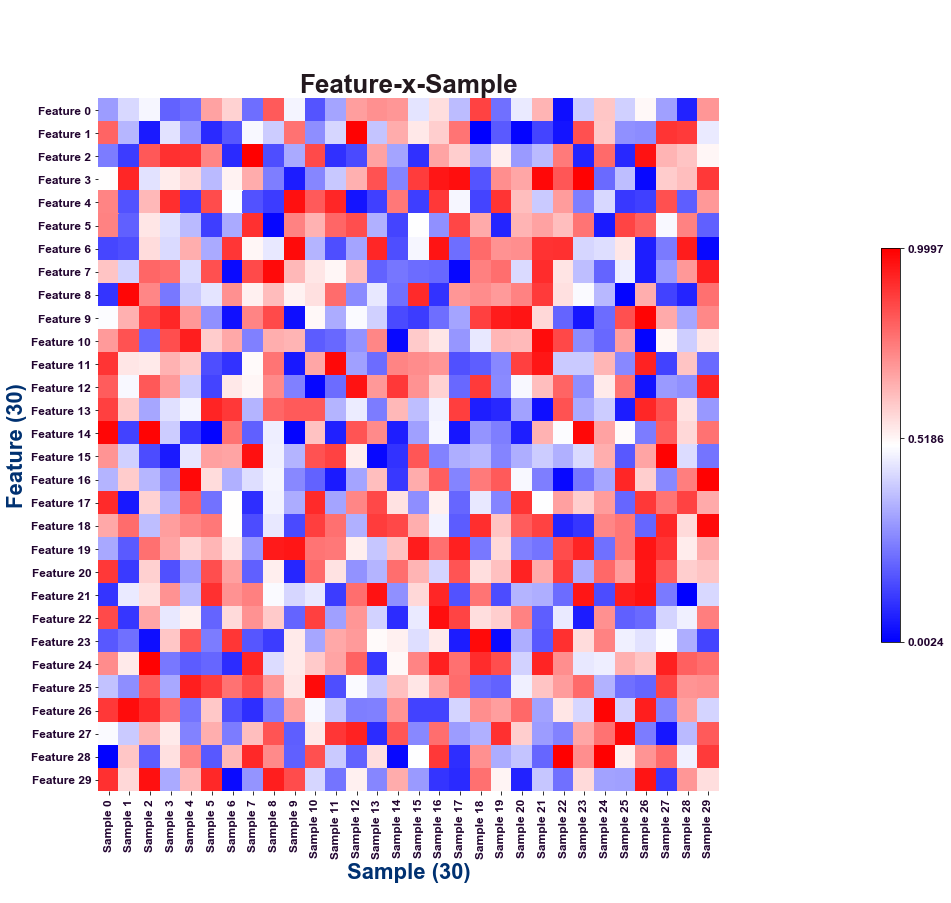

In [5]:
plot_heatmap(
    feature_x_sample,
    title='Feature-x-Sample',
    decorate_ax_kwargs={
        'xlabel': 'Sample',
        'ylabel': 'Feature',
    })

In [6]:
output_directory_path = clean_path('.')
print(output_directory_path)
assert os.path.isdir(output_directory_path)

/Users/k/Jumis/github_kwatme/ccal/notebook


In [7]:
n_job = 2

In [8]:
a_matrix_normalization_method = '0-1'
a_matrix_normalization_axis = 0
nmf_n_clustering = 10
nmf_parameters = '__'.join((str(parameter)
                            for parameter in (
                                'nmf',
                                a_matrix_normalization_axis,
                                a_matrix_normalization_method,
                                nmf_n_clustering, )))
print('NMF parameters: {}'.format(nmf_parameters))

nmf_ks = tuple(range(2, 4))

NMF parameters: nmf__0__0-1__10


In [9]:
h_hcc_distance_function = 'information'
h_hcc_n_clustering = nmf_n_clustering * 10
h_hcc_linkage_method = 'ward'
h_hcc_parameters = '__'.join((str(parameter)
                              for parameter in (
                                  'hcc',
                                  h_hcc_distance_function,
                                  h_hcc_n_clustering,
                                  h_hcc_linkage_method, )))
print('H HCC parameters: {}'.format(h_hcc_parameters))

h_hcc_ks = nmf_ks

H HCC parameters: hcc__information__100__ward


In [10]:
w_hcc_distance_function = h_hcc_distance_function
w_hcc_n_clustering = h_hcc_n_clustering
w_hcc_linkage_method = h_hcc_linkage_method
w_hcc_parameters = '__'.join((str(parameter)
                              for parameter in (
                                  'hcc',
                                  w_hcc_distance_function,
                                  w_hcc_n_clustering,
                                  w_hcc_linkage_method, )))
print('W HCC parameters: {}'.format(w_hcc_parameters))

w_hcc_ks = h_hcc_ks

W HCC parameters: hcc__information__100__ward


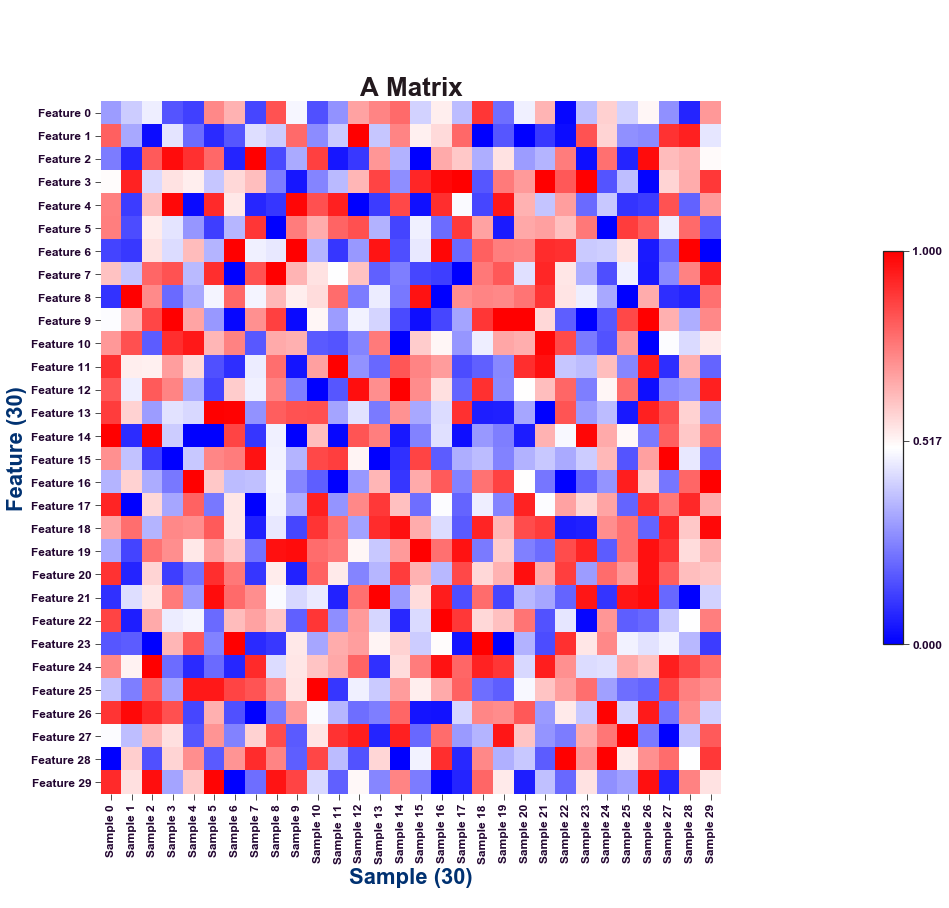

In [11]:
a = pd.DataFrame(
    normalize_2d_array(feature_x_sample.values, a_matrix_normalization_method,
                       a_matrix_normalization_axis),
    index=feature_x_sample.index,
    columns=feature_x_sample.columns)

a = a.loc[(a != 0).any(axis=1)]

plot_heatmap(
    a,
    title='A Matrix',
    decorate_ax_kwargs={
        'xlabel': 'Sample',
        'ylabel': 'Feature',
    })

NMFCC with K=2 ...
NMFCC with K=3 ...
	(K=2) 10/10 - done.
	(K=3) 10/10 - done.


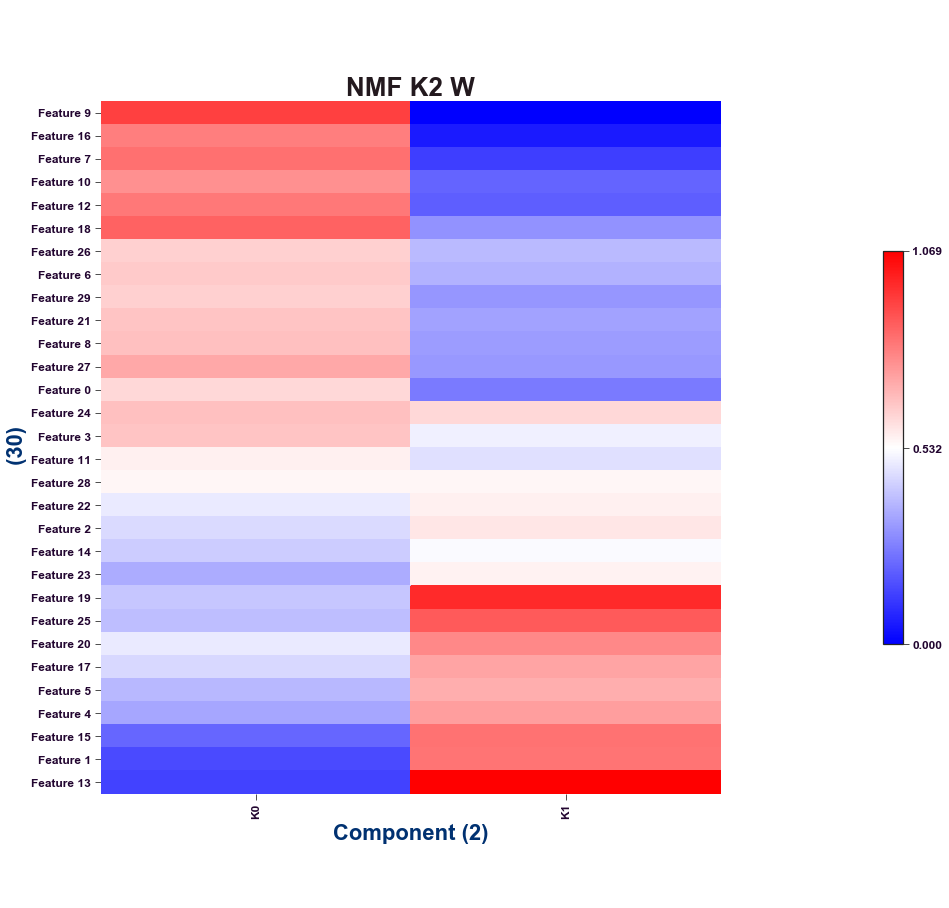

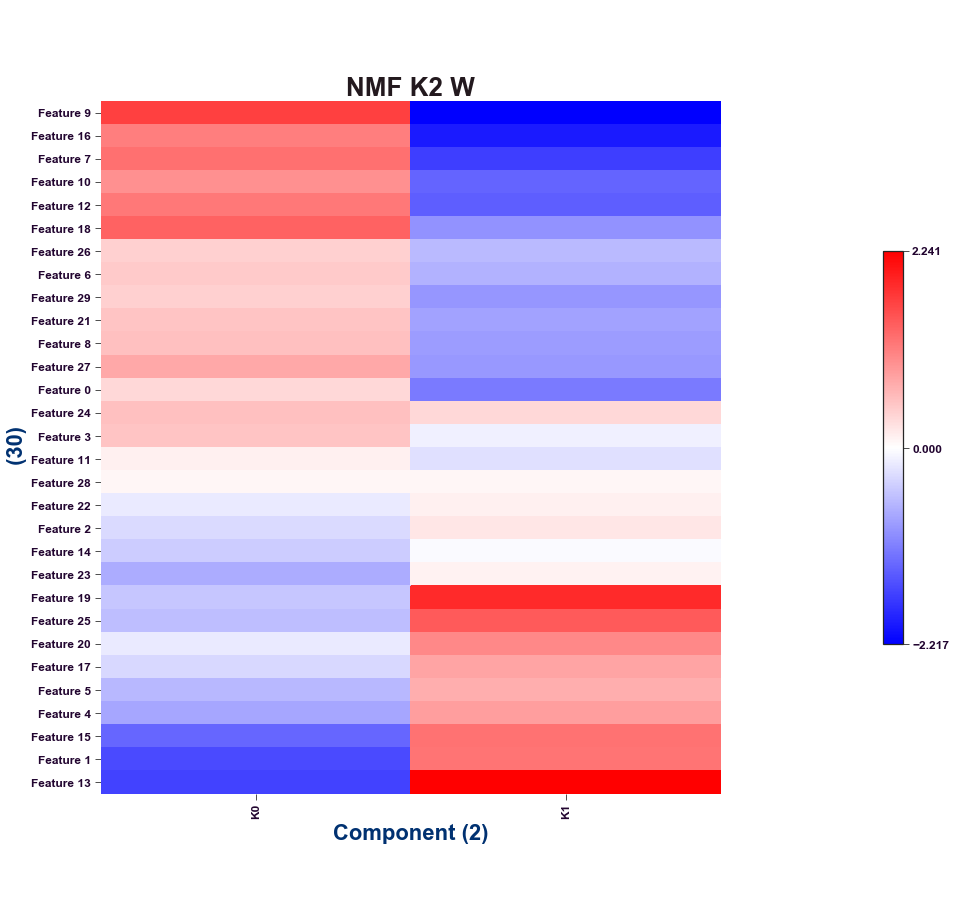

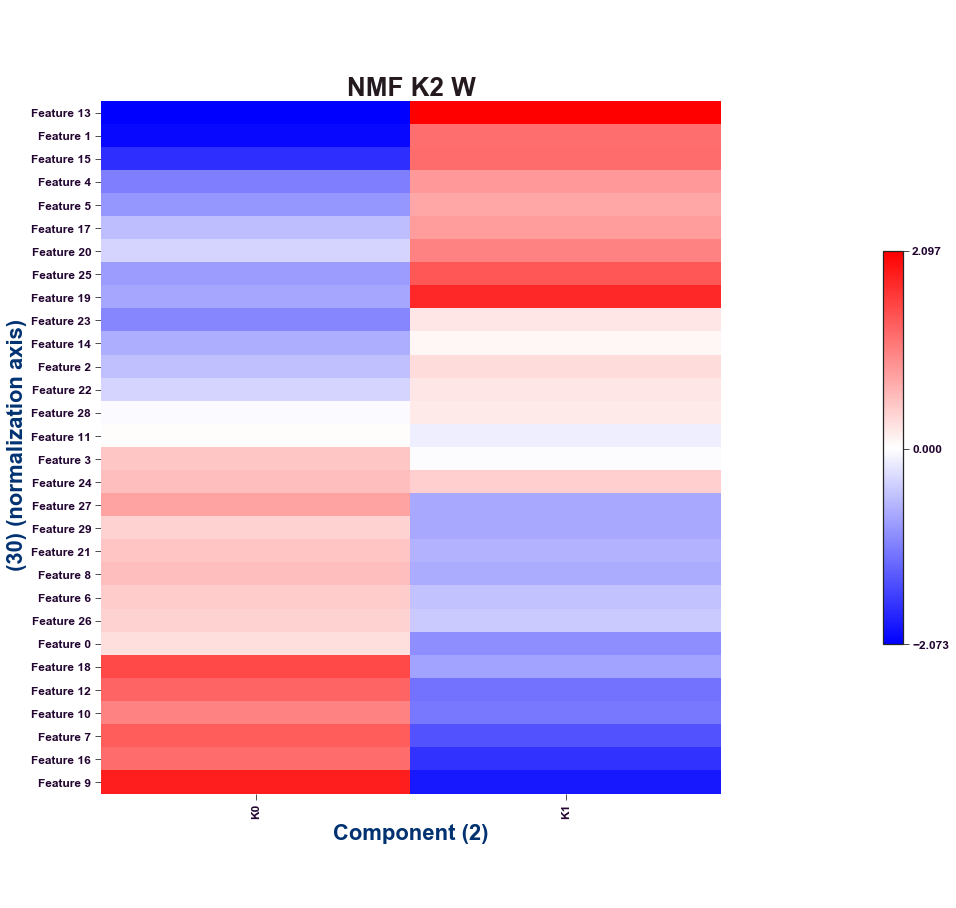

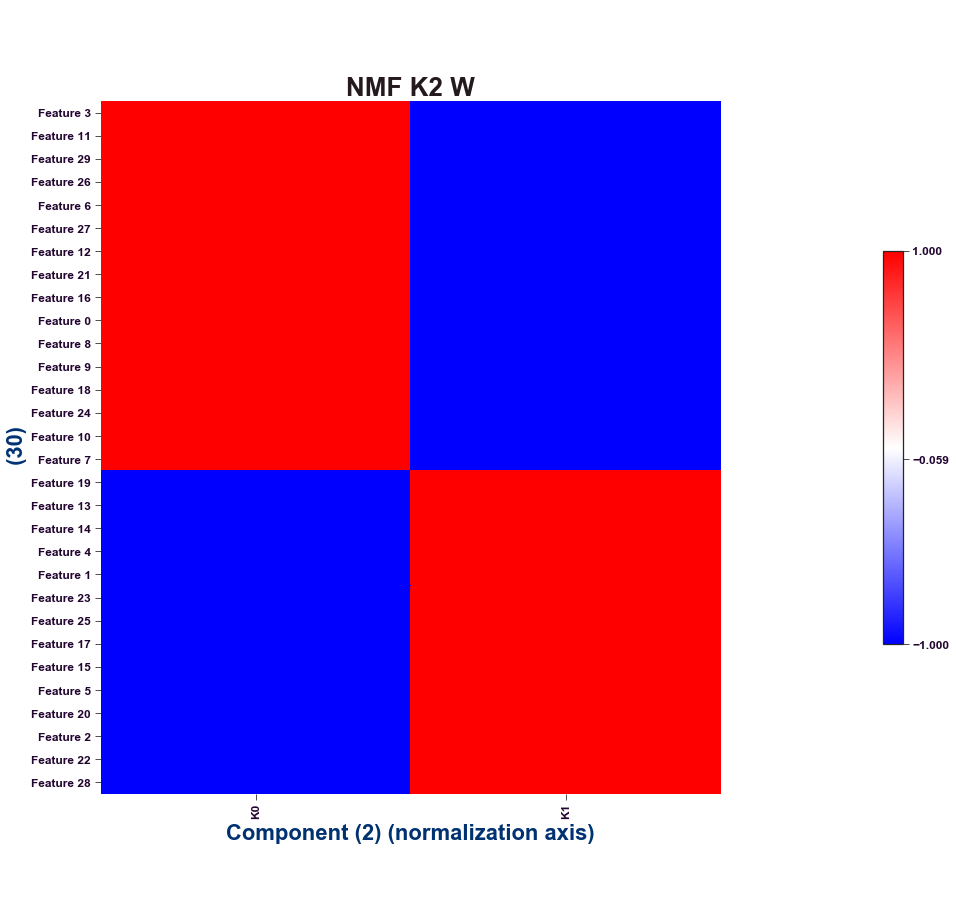

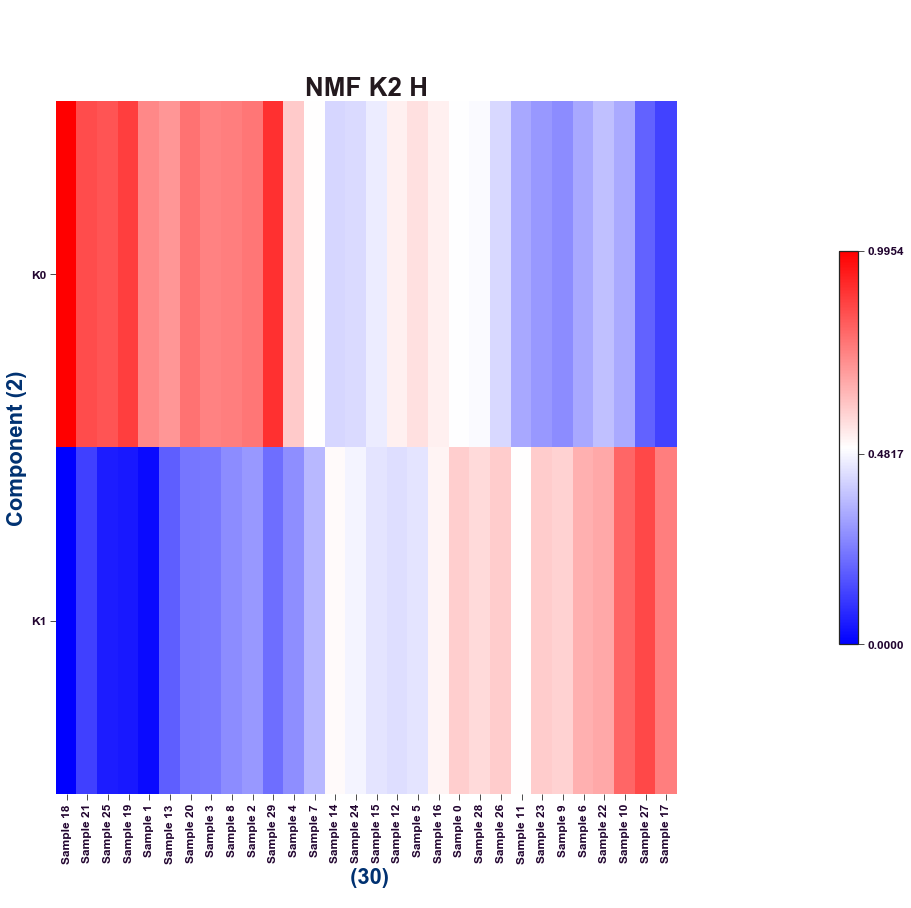

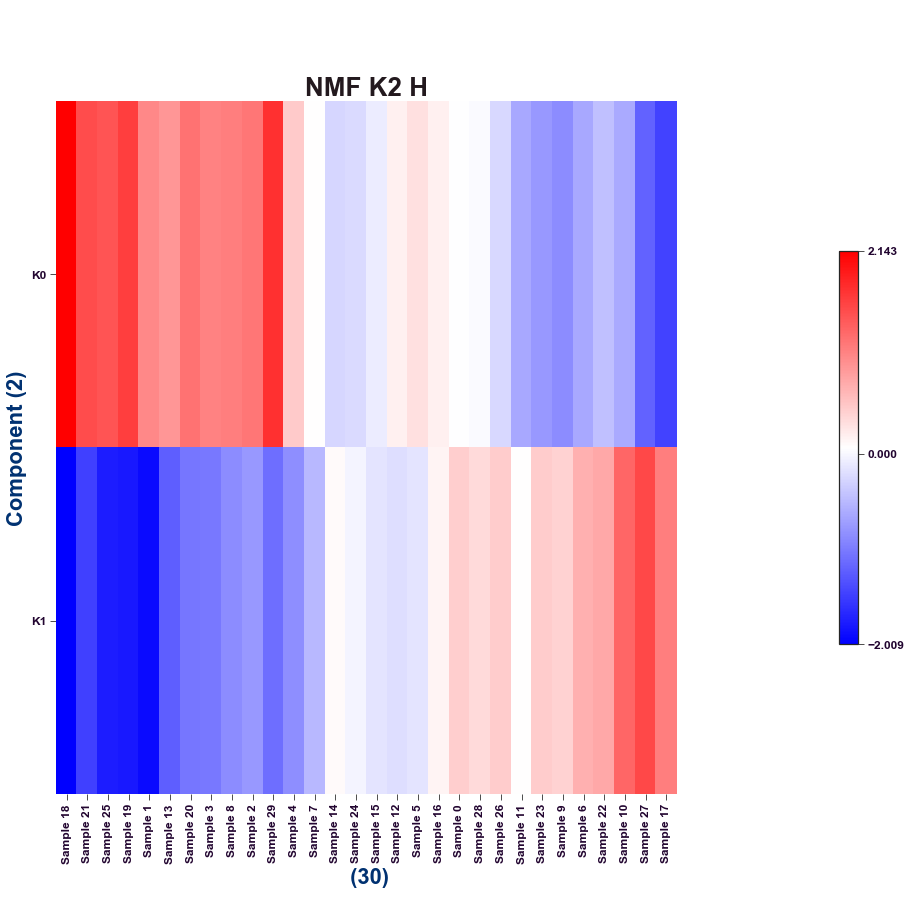

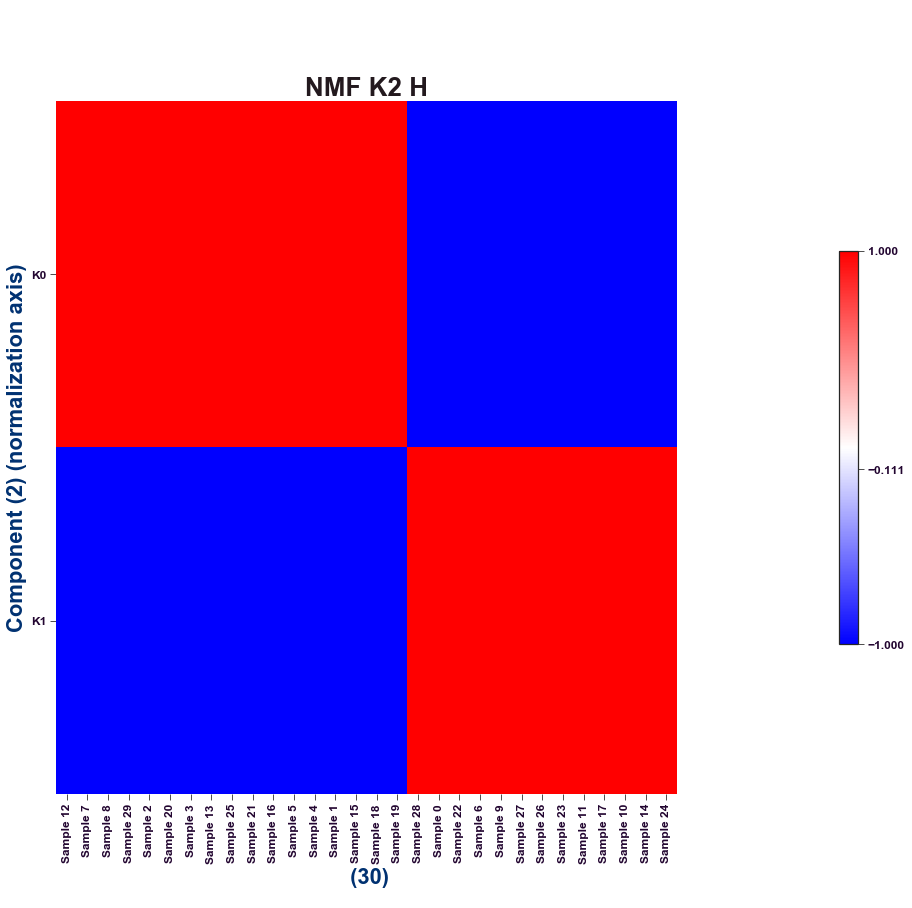

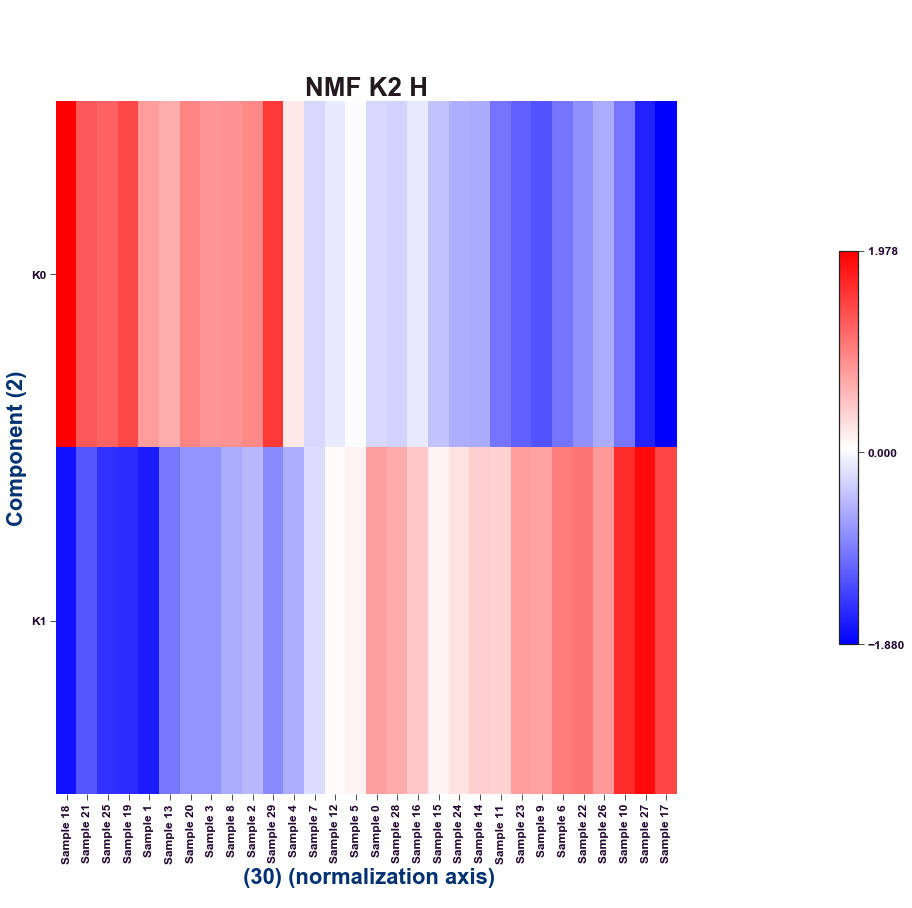

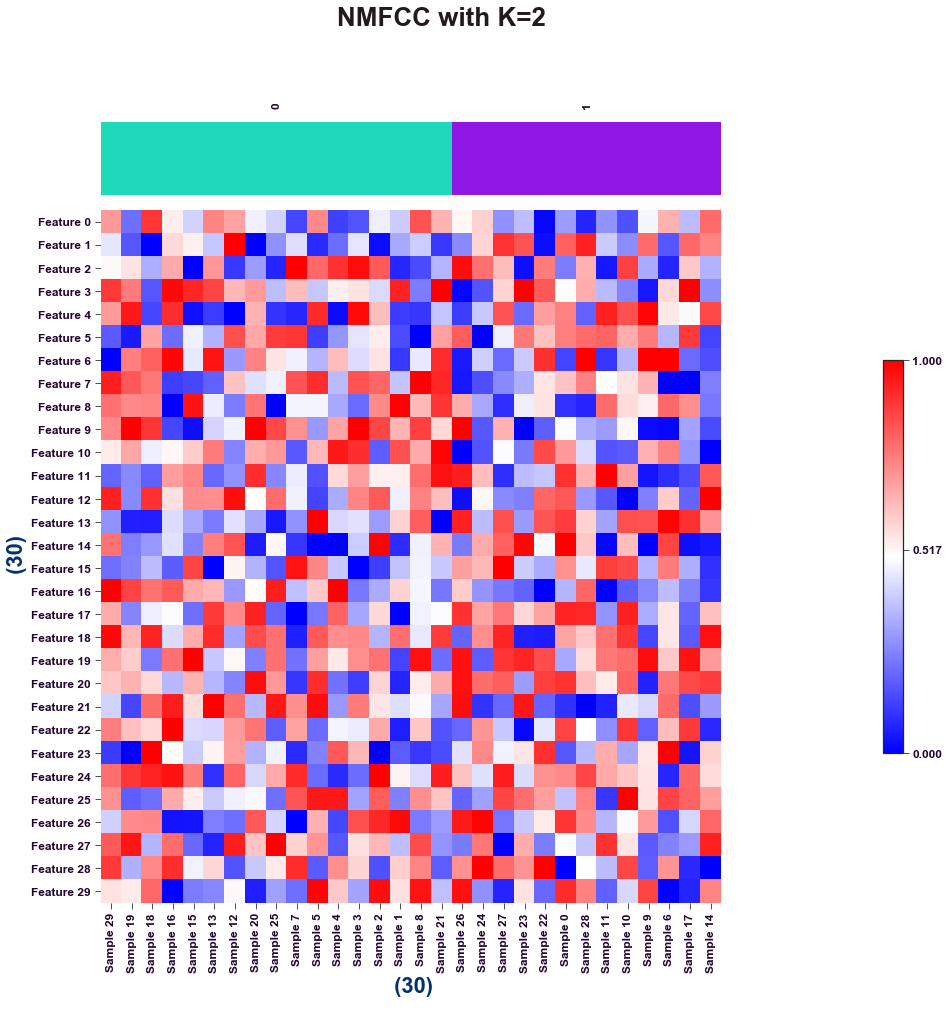

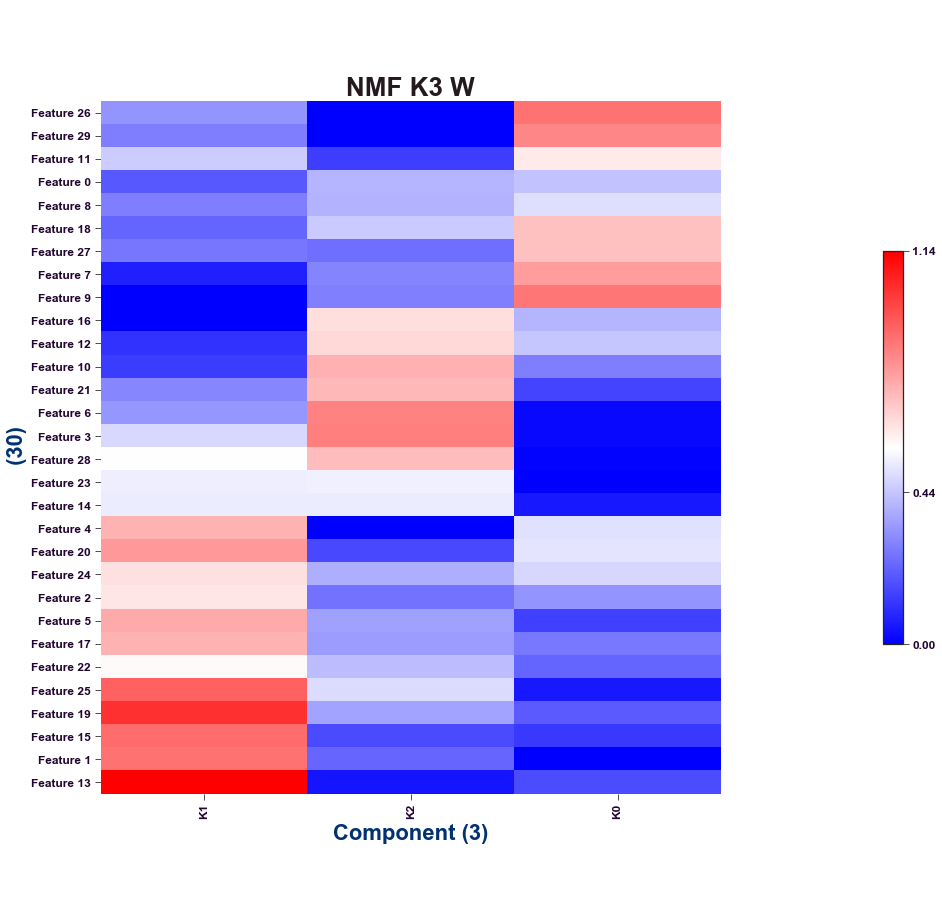

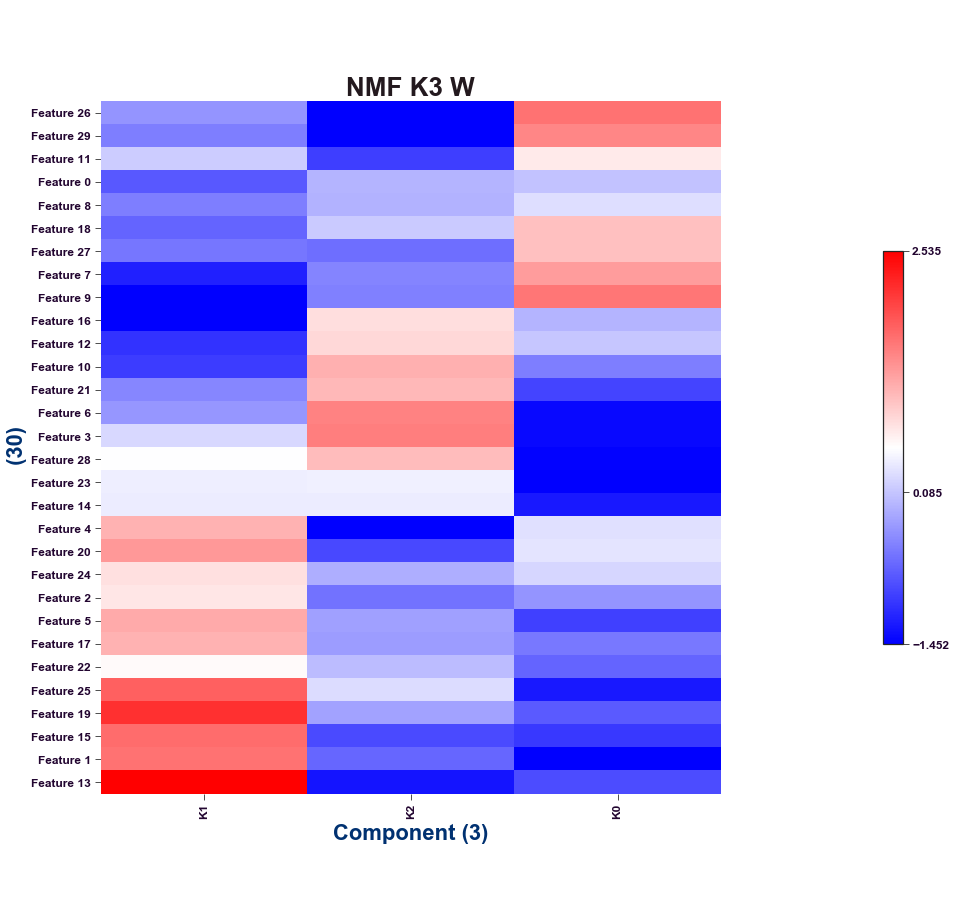

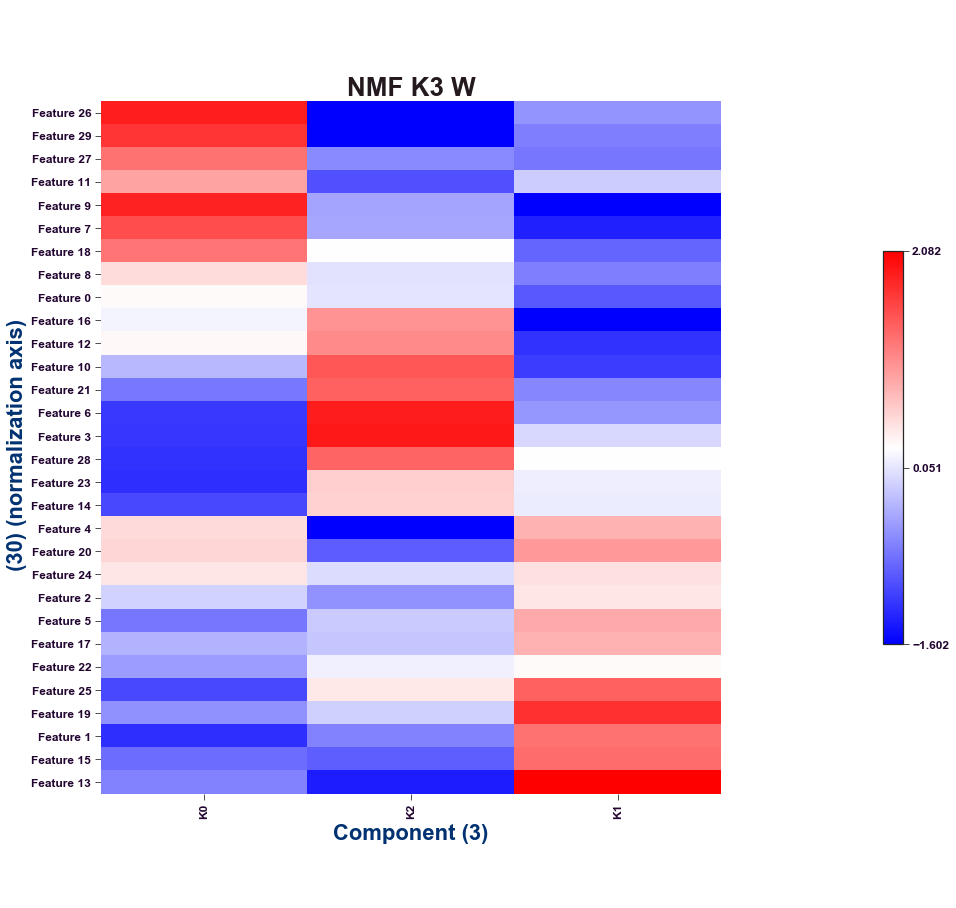

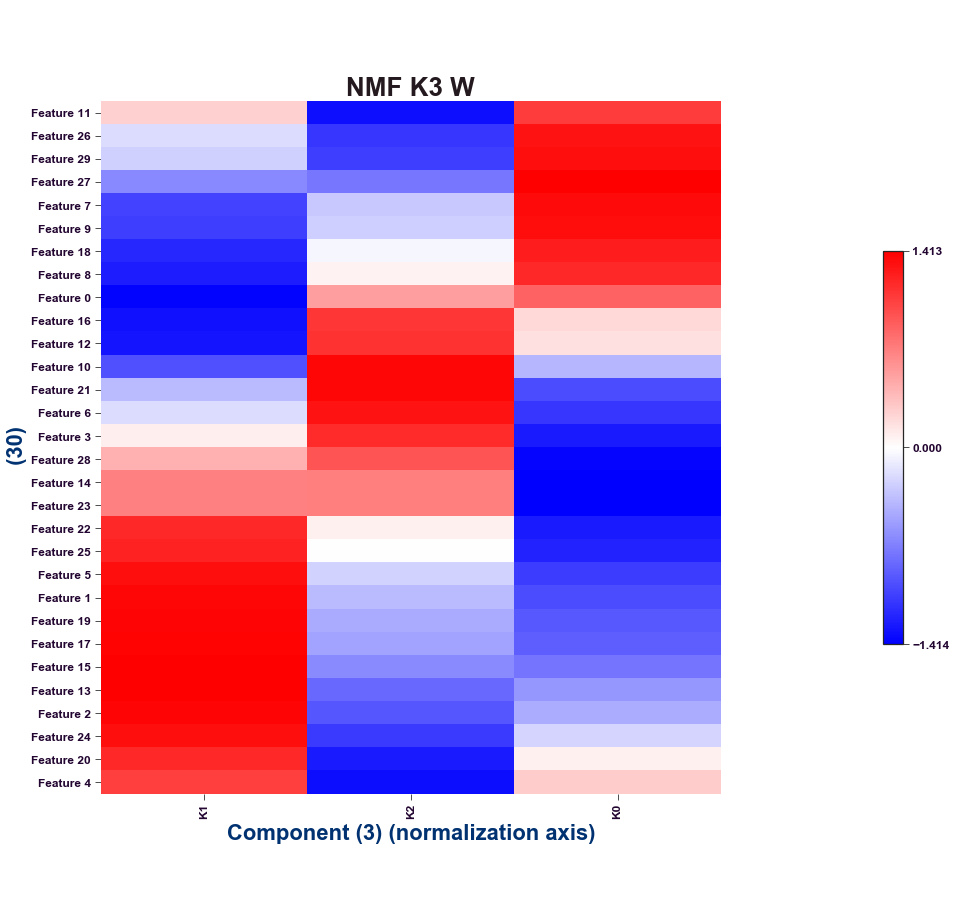

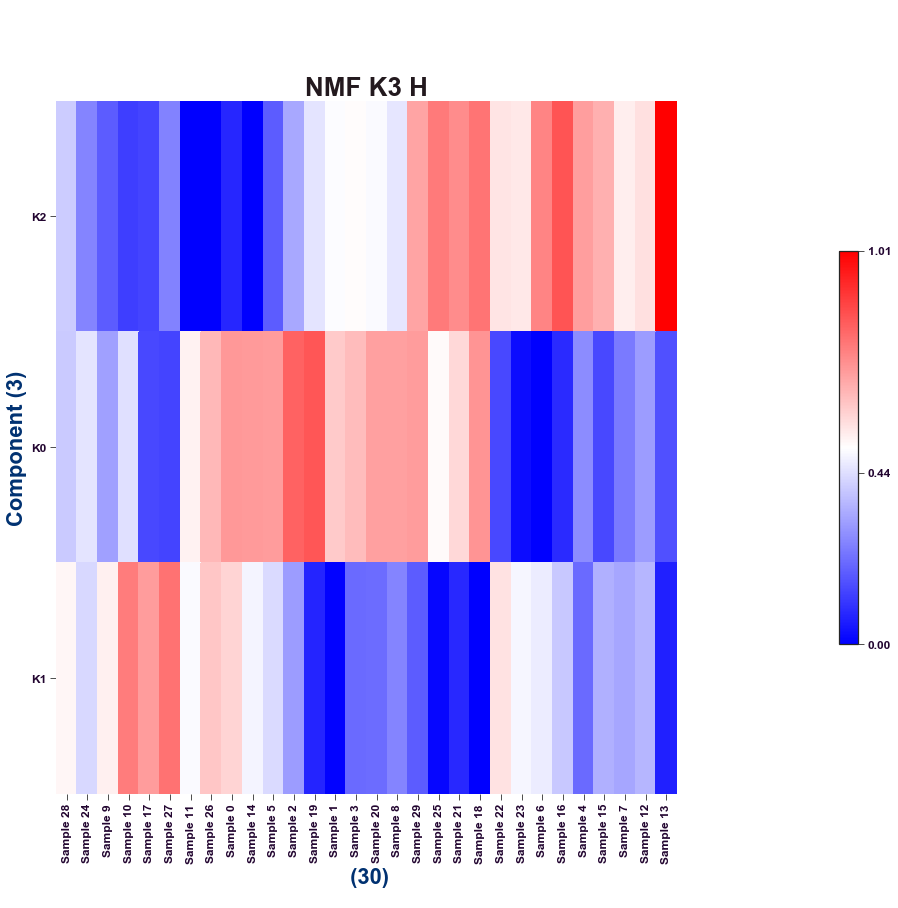

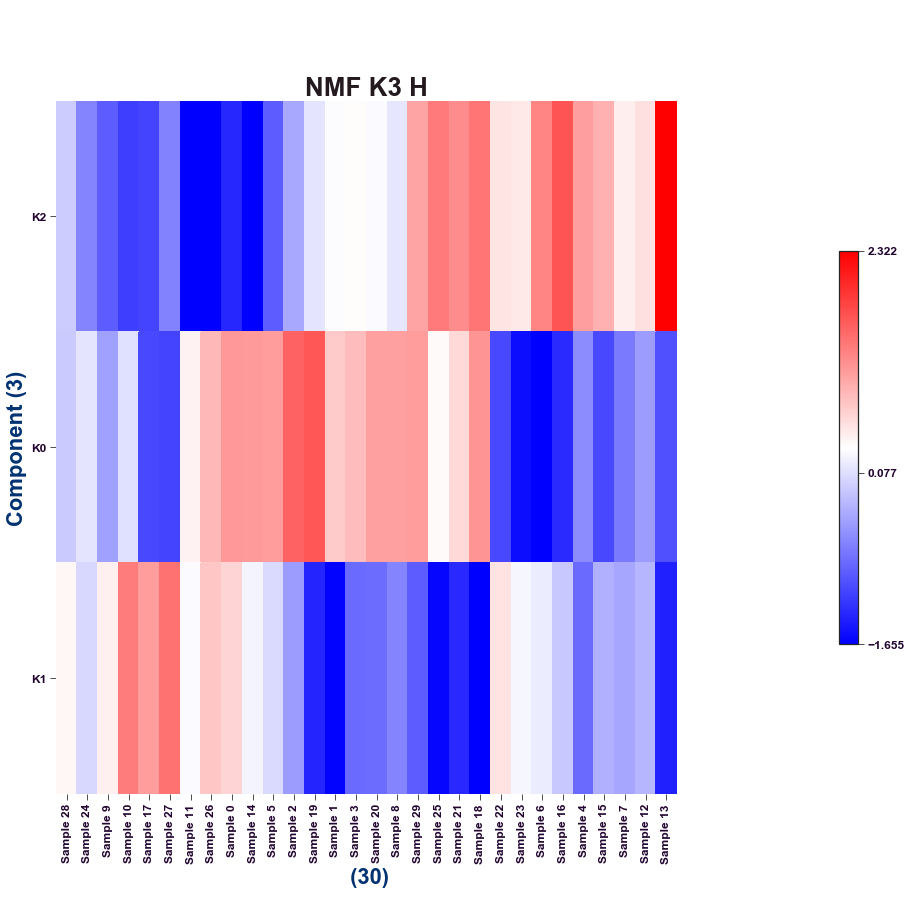

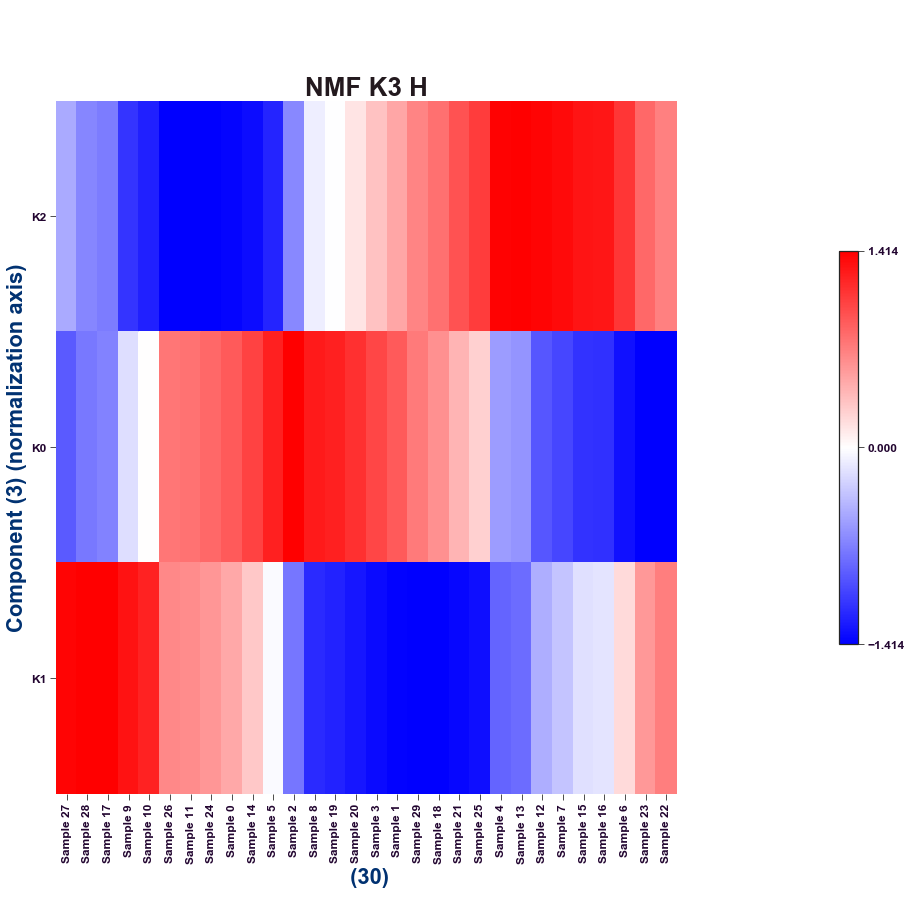

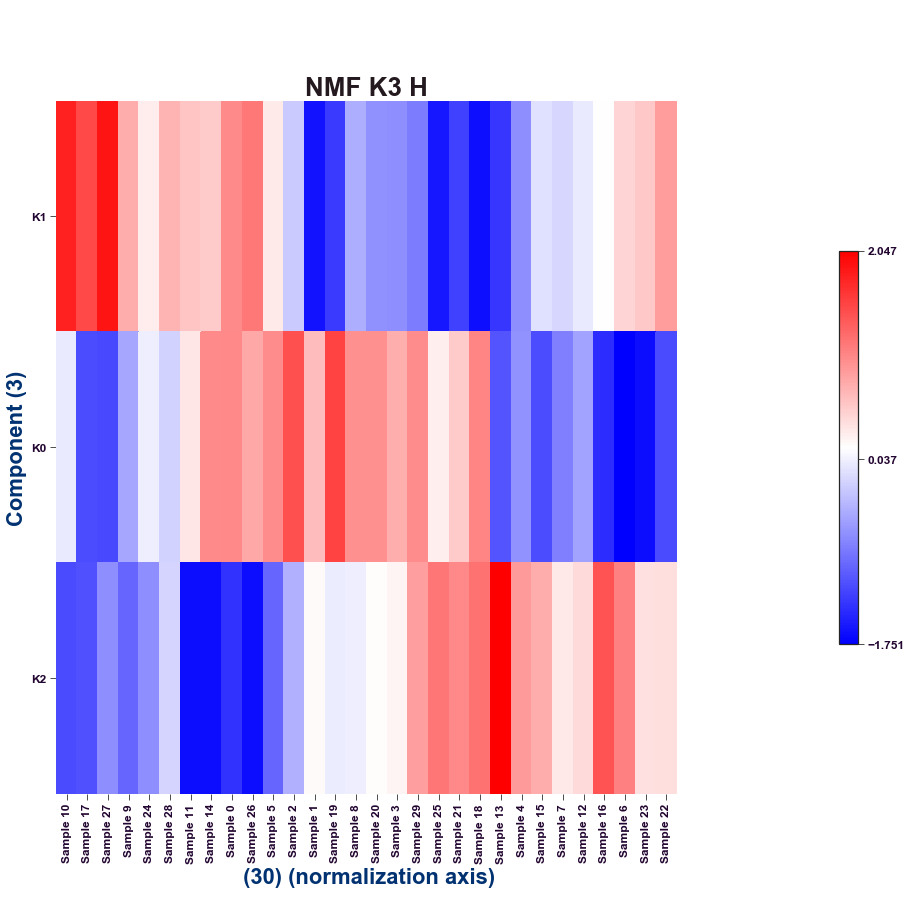

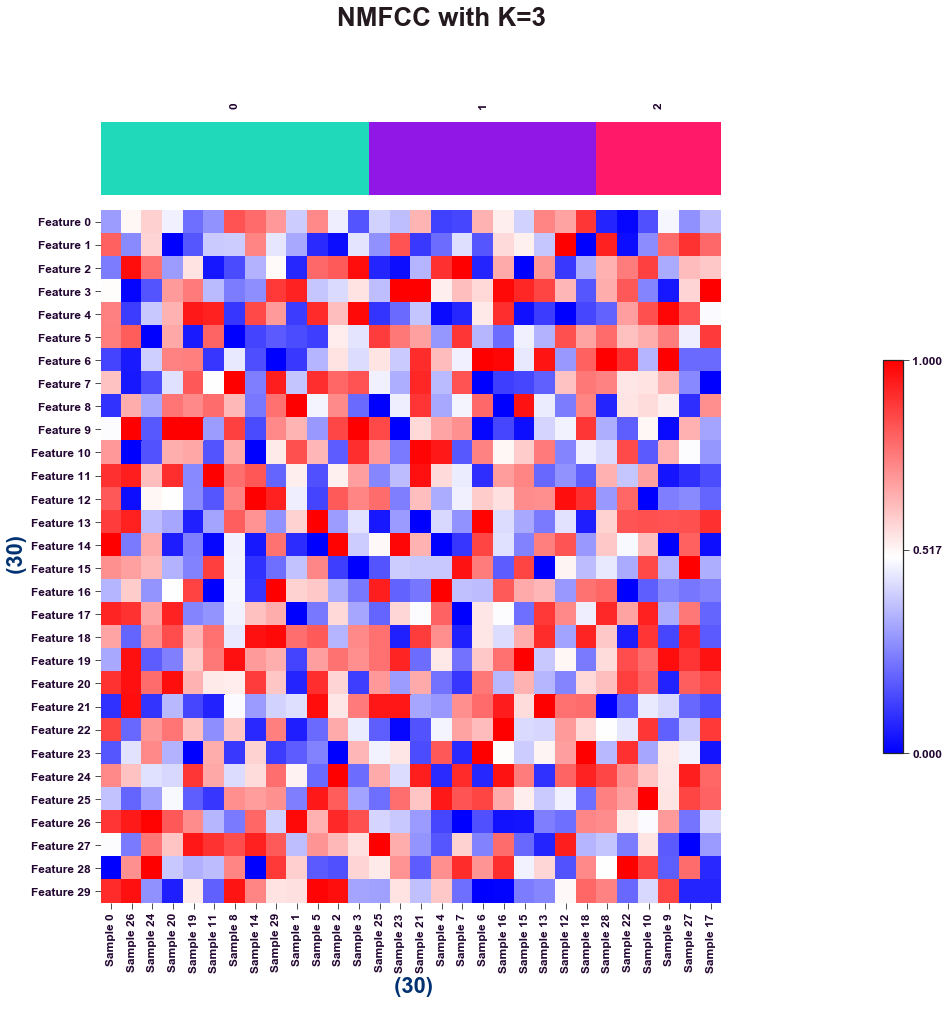

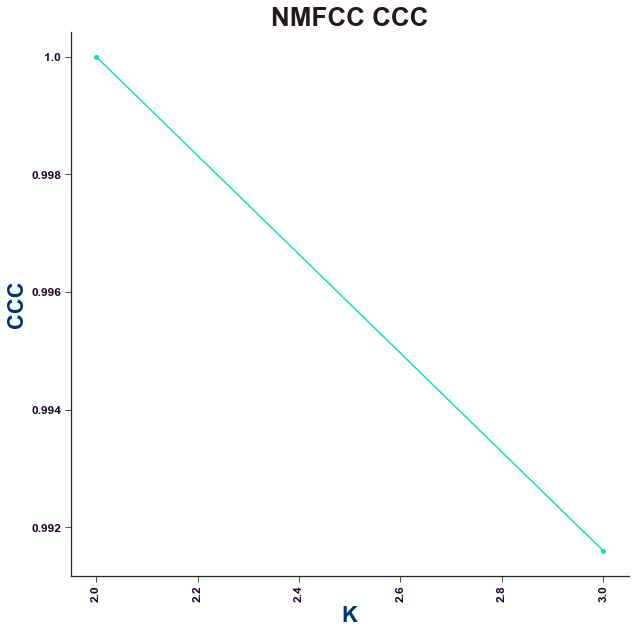

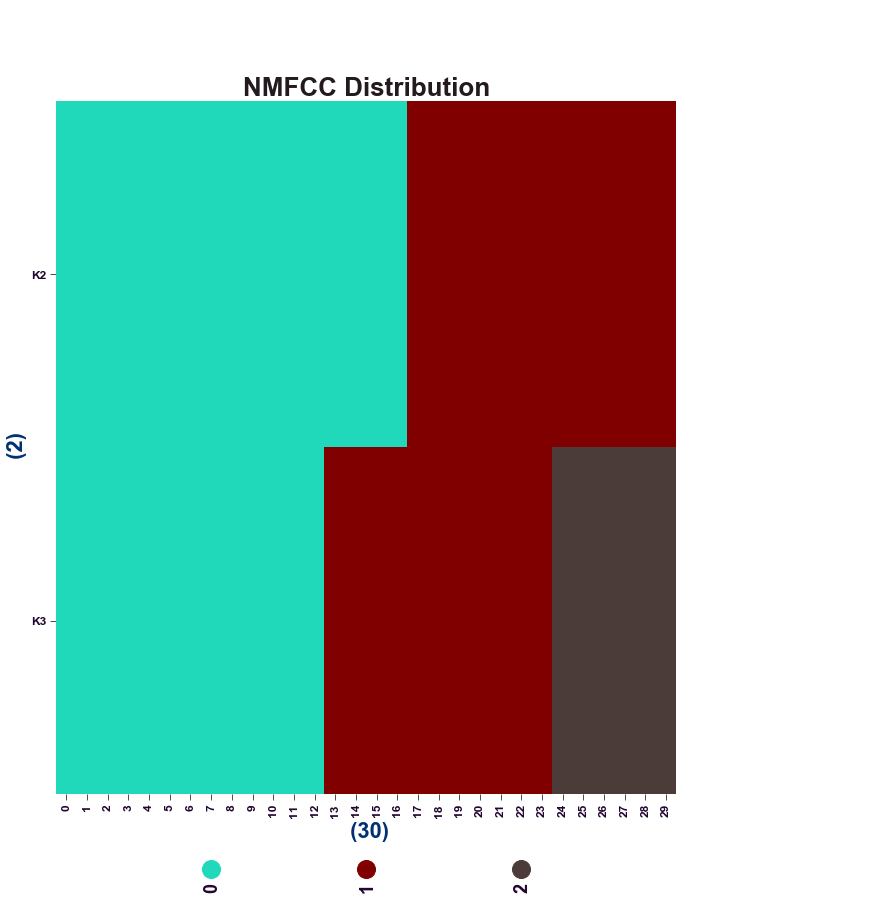

In [12]:
k_nmf, k_nmfcc_distance_linkage_ccc, nmfcc__k_x_column = nmf_consensus_cluster_with_multiple_k(
    a,
    nmf_ks,
    n_job=n_job,
    n_clustering=nmf_n_clustering,
    directory_path='{}/{}'.format(output_directory_path, nmf_parameters))

In [14]:
nmf_k = 3

Applying <function compute_information_coefficient at 0x11b5620d0> ...
	1/3 ...
	3/3 - done.
Applying <function compute_information_coefficient at 0x11b5620d0> ...
	1/3 ...
	3/3 - done.


,K0,K1,K2
K0,0.968320,-0.302828,-0.235953
K1,-0.302828,0.973212,-0.667009
K2,-0.235953,-0.667009,0.971150


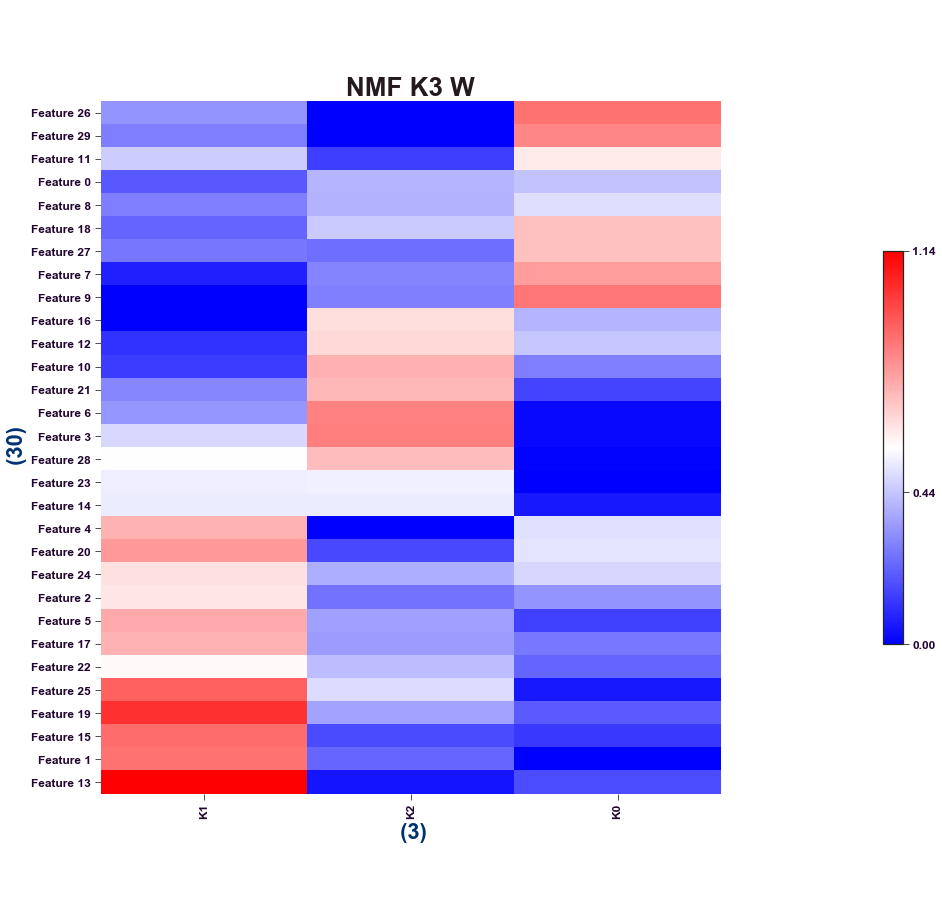

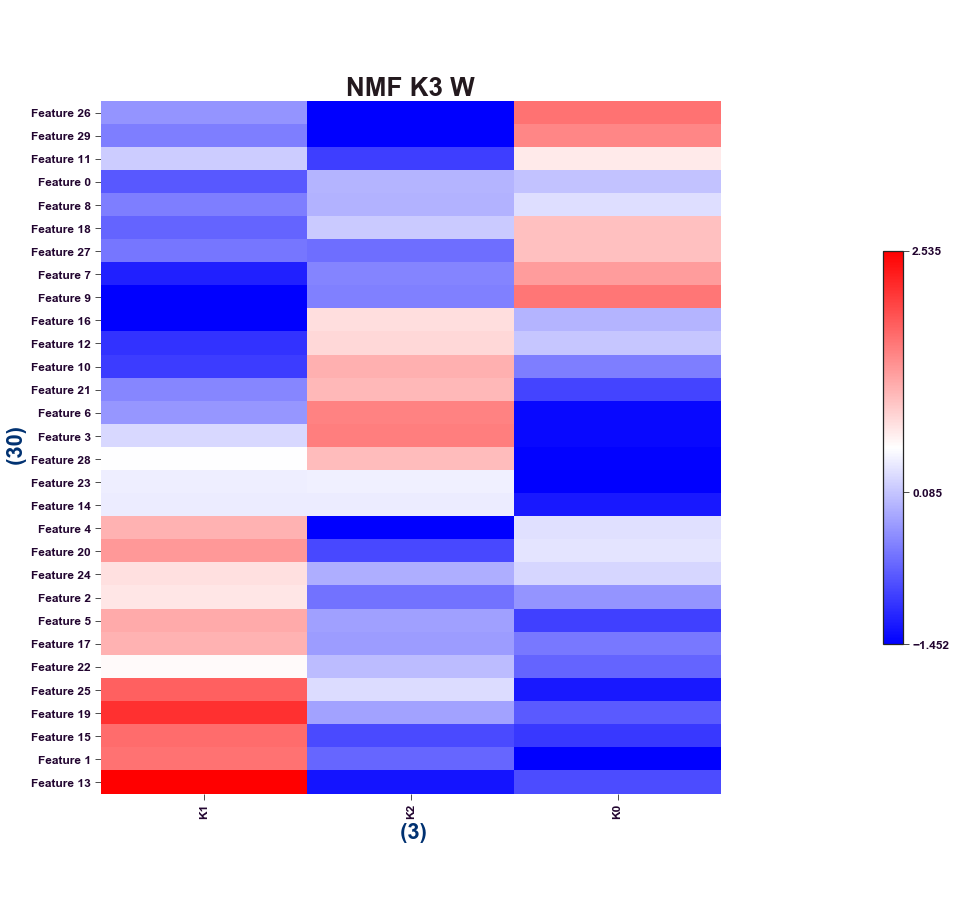

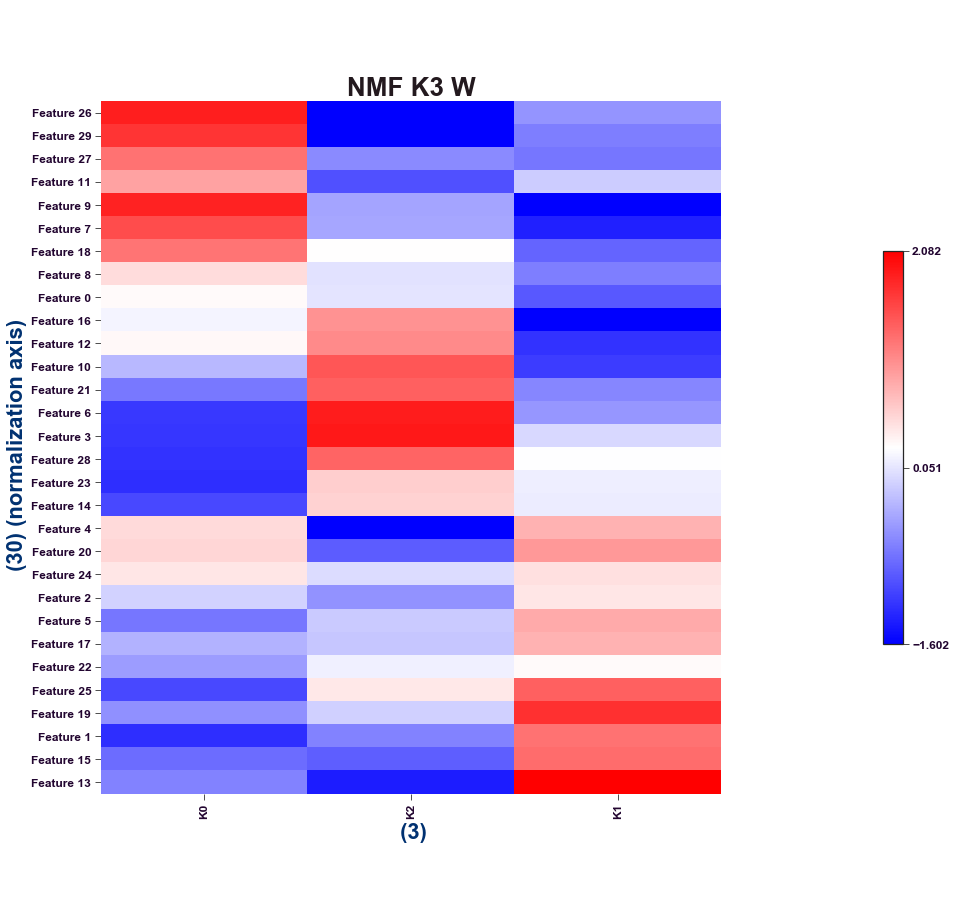

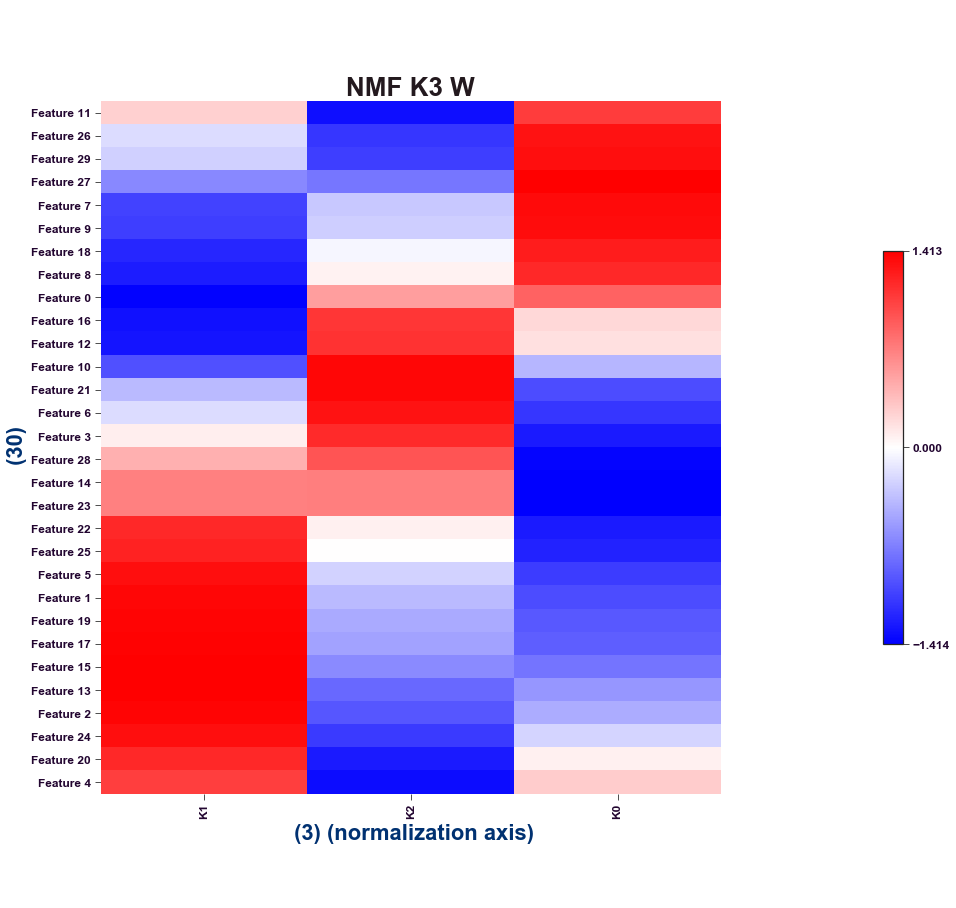

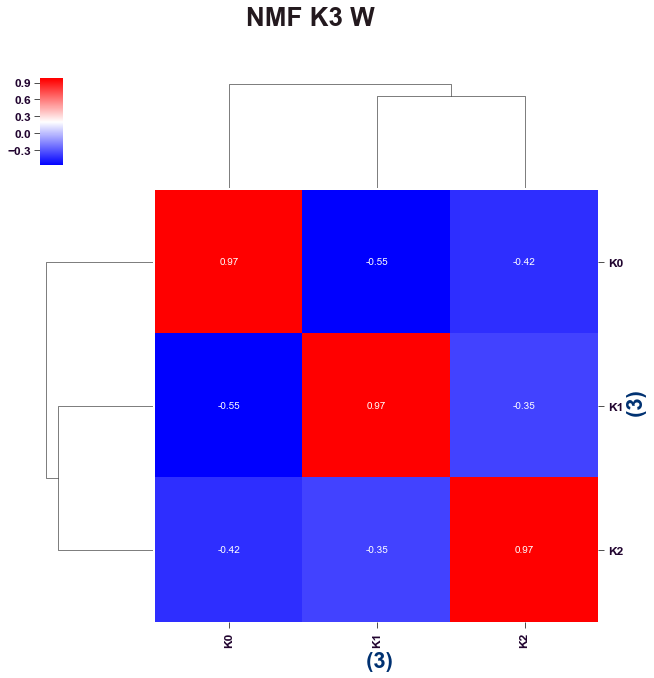

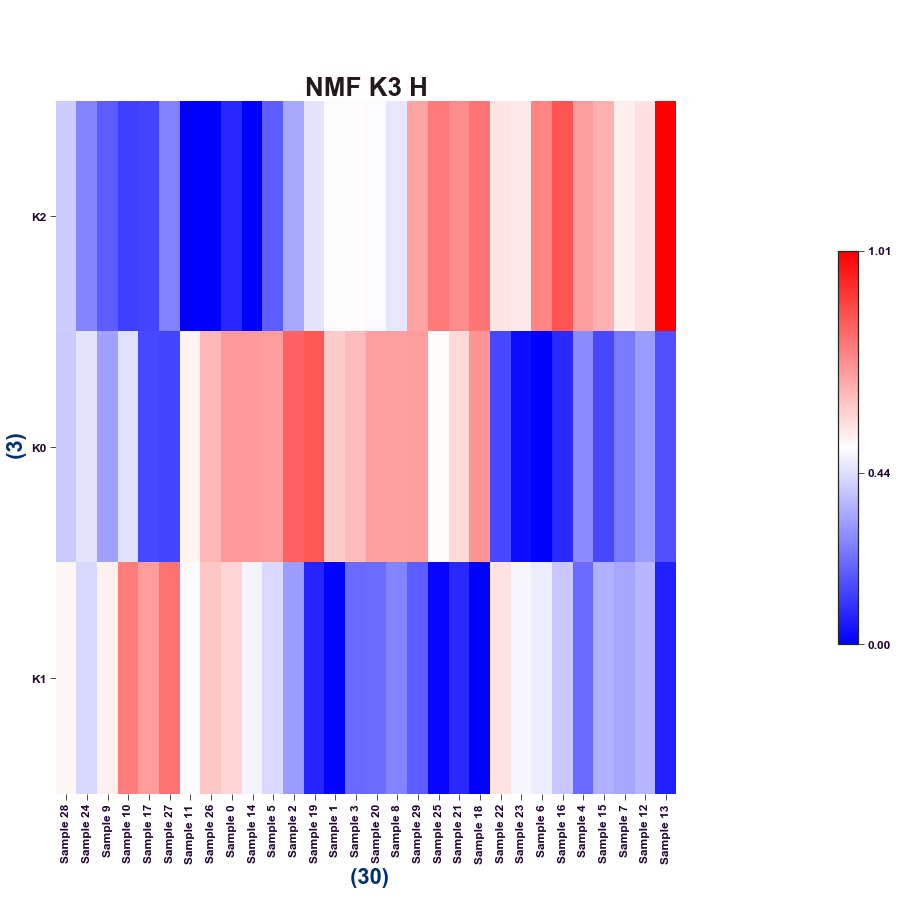

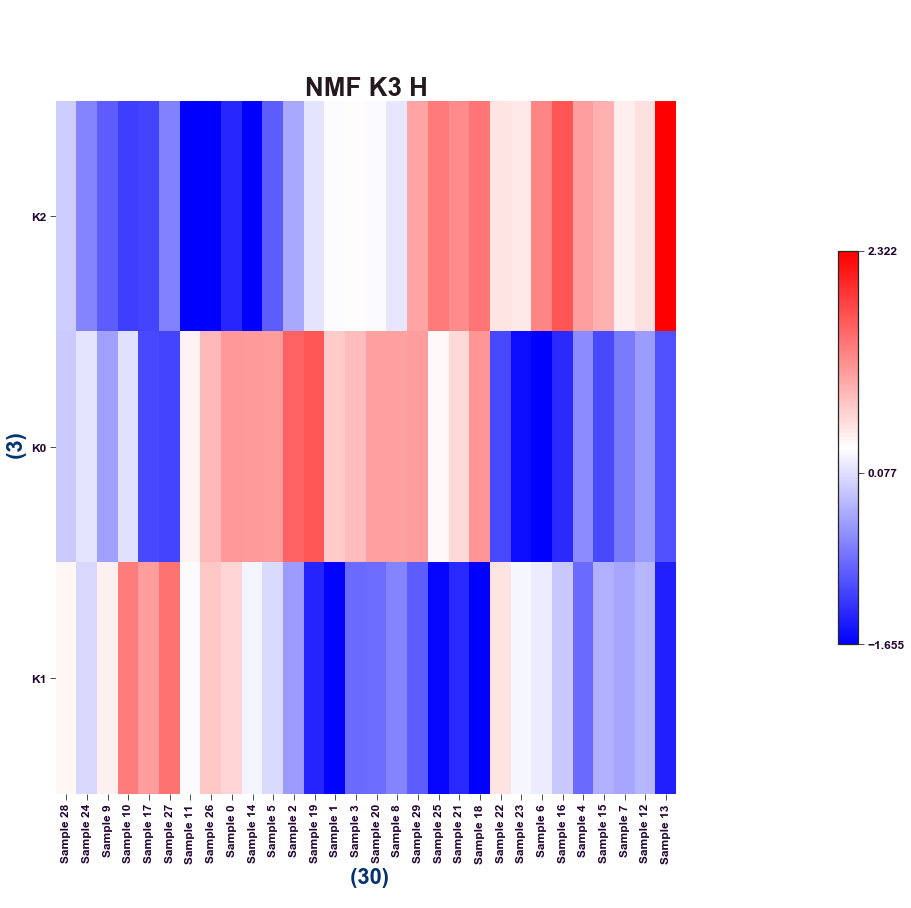

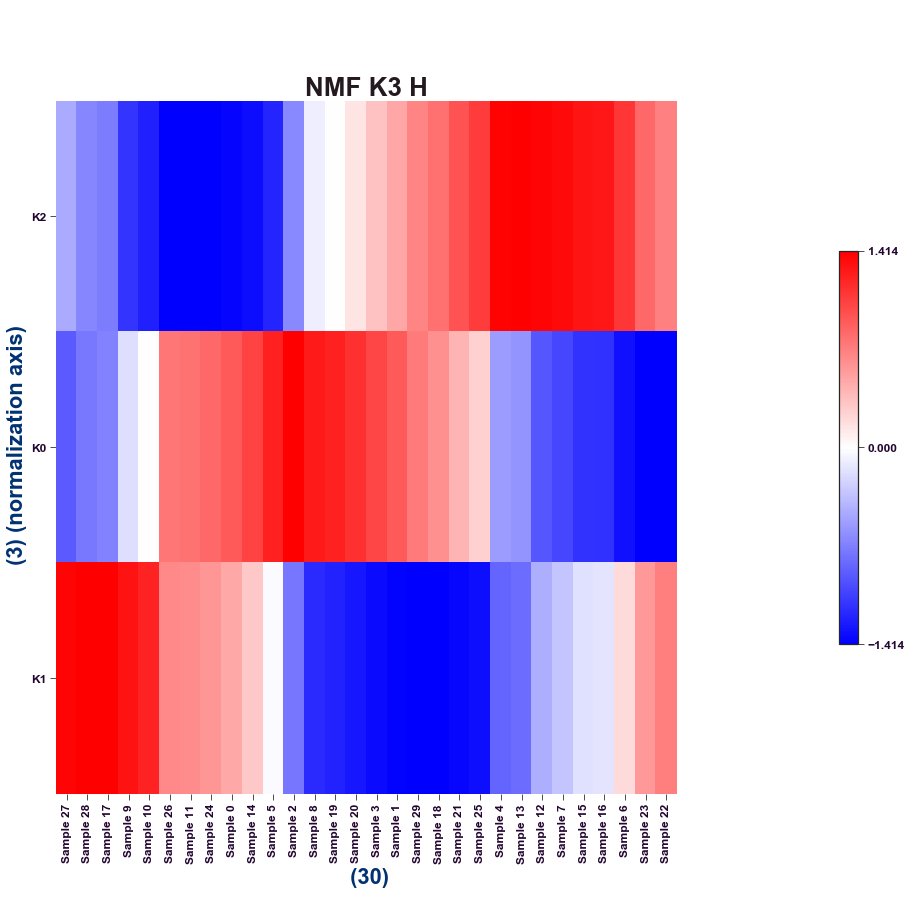

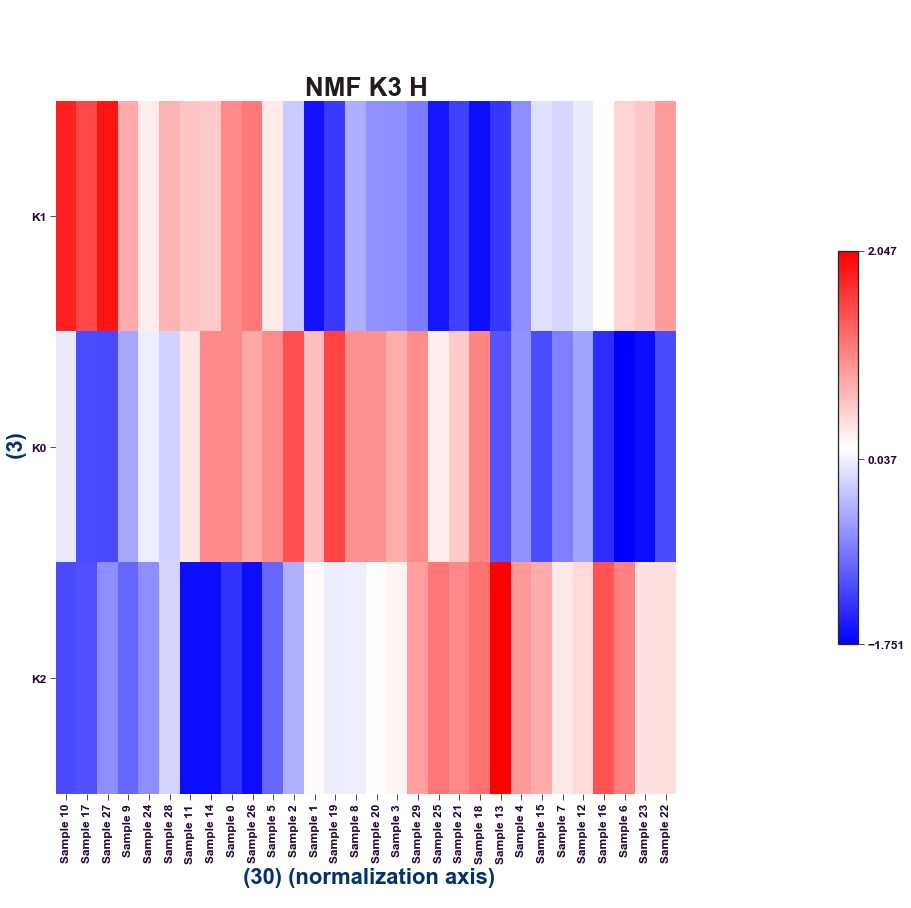

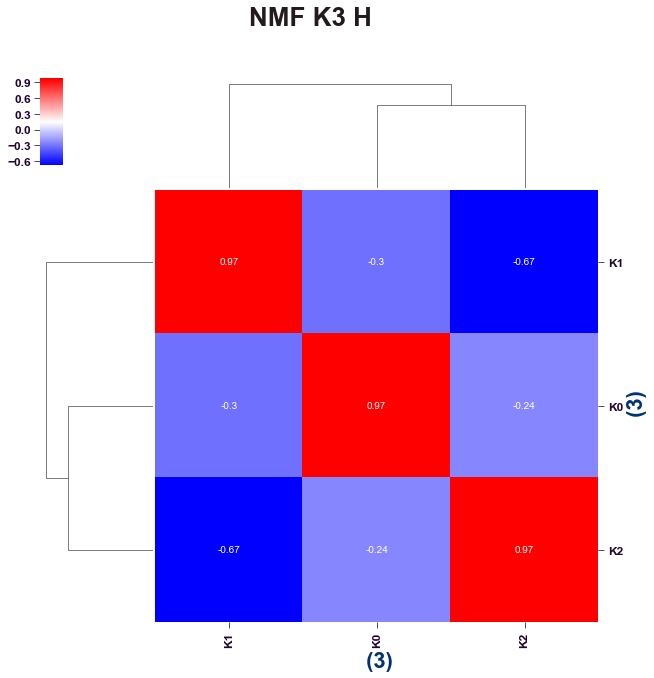

In [15]:
# w = pd.read_table(
#     '{}/{}/nmf_k{}_w.tsv'.format(output_directory_path, nmf_parameters, nmf_k),
#     index_col=0)

# h = pd.read_table(
#     '{}/{}/nmf_k{}_h.tsv'.format(output_directory_path, nmf_parameters, nmf_k),
#     index_col=0)

w = k_nmf['K{}'.format(nmf_k)]['w']

h = k_nmf['K{}'.format(nmf_k)]['h']

title = 'NMF K{} W'.format(nmf_k)
normalize_and_plot_heatmap(w, title=title)
make_comparison_panel(w, w, title=title)

title = 'NMF K{} H'.format(nmf_k)
normalize_and_plot_heatmap(h, title=title)
make_comparison_panel(h, h, axis=1, title=title)

In [34]:
normalzied_h = pd.DataFrame(
    clip_nd_array_by_standard_deviation(h.values),
    index=h.index,
    columns=h.columns)

Created directory /Users/k/Jumis/github_kwatme/ccal/notebook/nmf__0__0-1__10/3/h/hcc__information__100__ward.
Computing column-x-column distance with <function compute_information_distance at 0x11b4776a8> ...
HCC with K=3 ...
HCC with K=2 ...
	(K=3) 100/100 - done.
	(K=2) 100/100 - done.


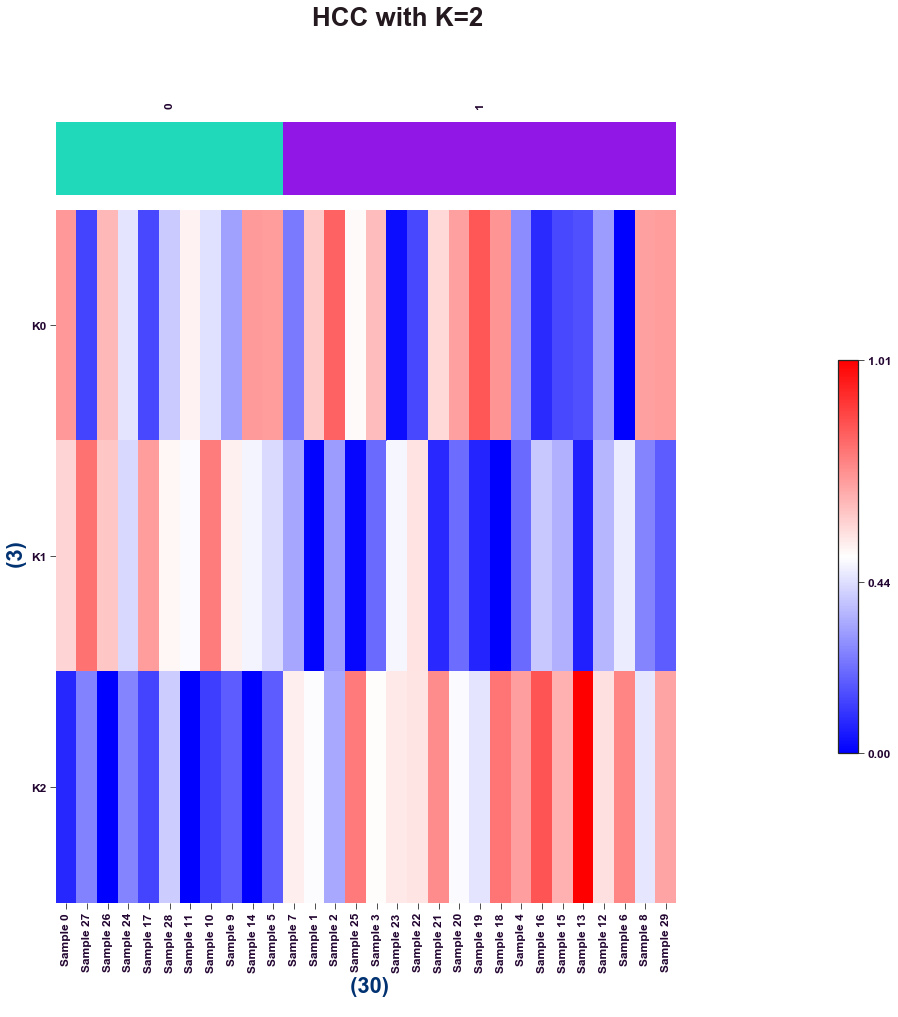

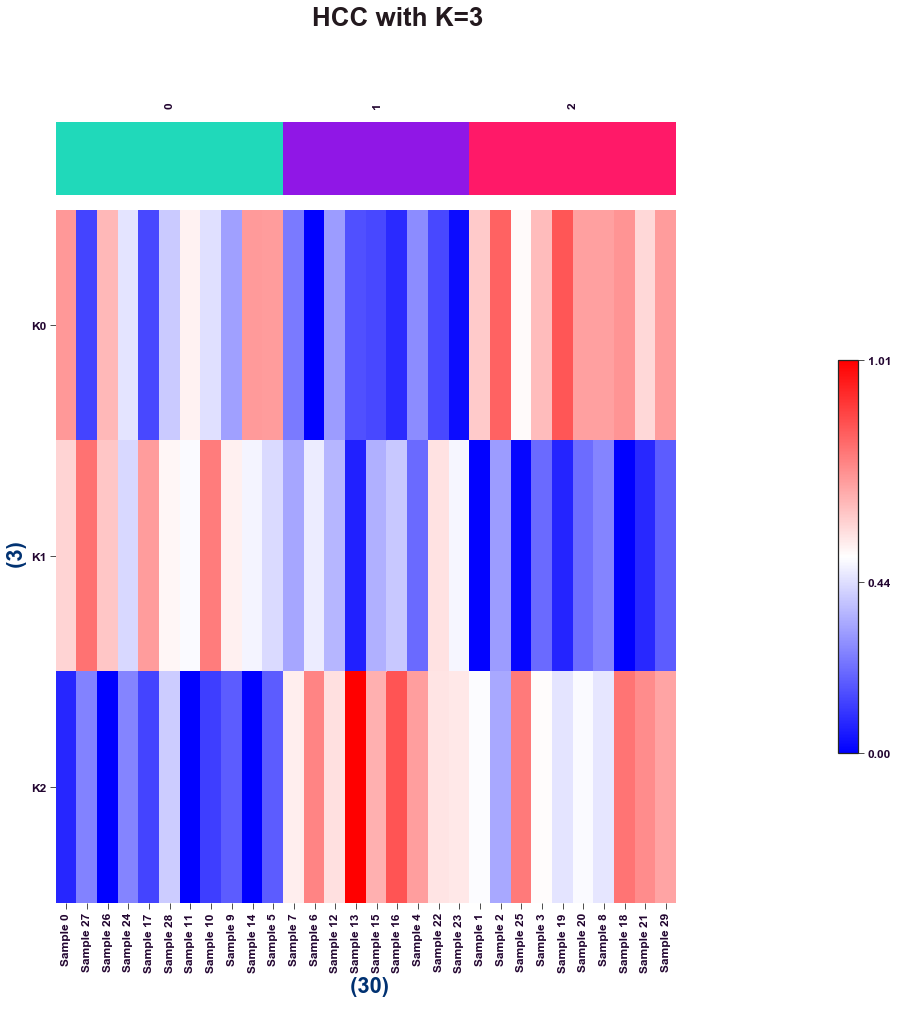

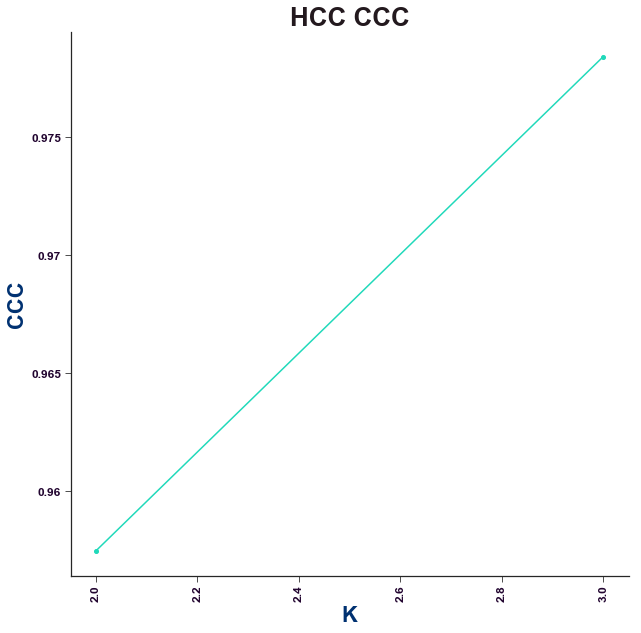

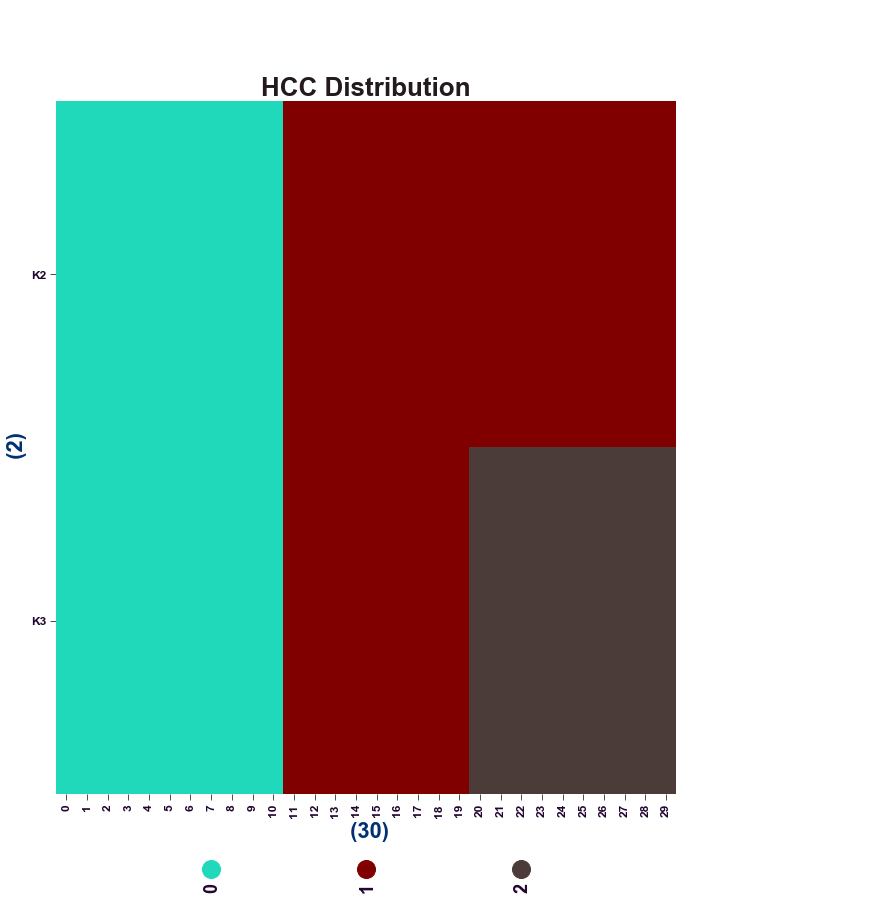

In [27]:
if h_hcc_distance_function == 'information':
    h_hcc_distance_function = compute_information_distance

distance__column_x_column, k_hcc_distance_linkage, k_hcc_distance_linkage_ccc, hcc__k_x_column = hierarchical_consensus_cluster_with_multiple_k(
    normalized_h,
    h_hcc_ks,
    n_job=n_job,
    distance_function=h_hcc_distance_function,
    n_clustering=h_hcc_n_clustering,
    linkage_method=h_hcc_linkage_method,
    directory_path='{}/{}/{}/h/{}'.format(
        output_directory_path, nmf_parameters, nmf_k, h_hcc_parameters))

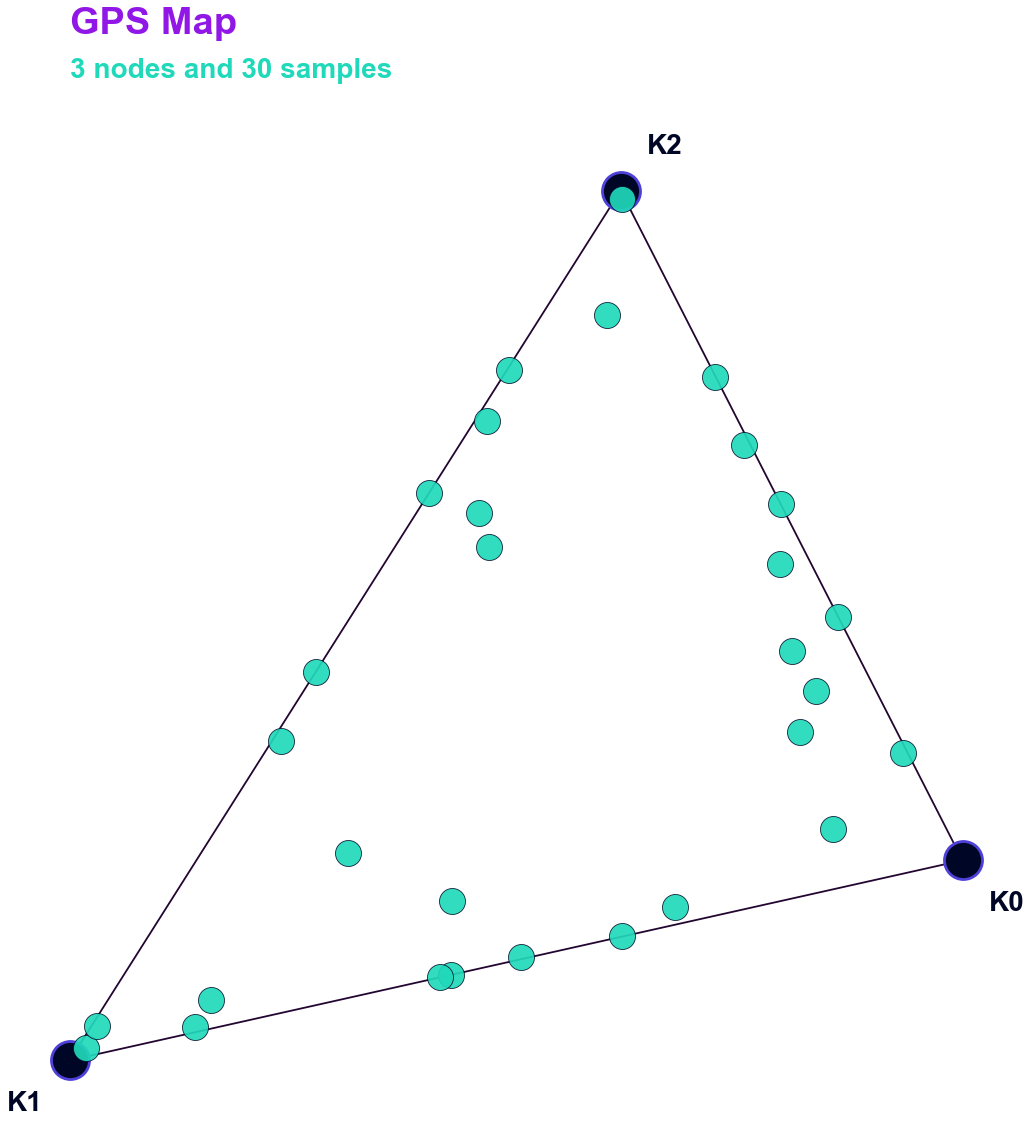

In [28]:
gps_map = GPSMap(
    normalized_h,
    pull_power=2.6,
    mds_distance_function=compute_information_distance)

gps_map.sample_marker_style.update({
    'markersize': 26,
})

gps_map.plot_samples()

In [ ]:
for hcc_k, sample_state in hcc__k_x_column.iterrows():

    if sample_state.value_counts().min() < 3:
        print(
            'Skipping {}, who has at least 1 state with less than 3 samples ...'.
            format(hcc_k))

    else:
        hcc_k = int(hcc_k.strip('K'))

        gps_map.set_sample_phenotypes(
            sample_state,
            bandwidth_factor=2.6,
            phenotype_to_str={i: 'State {}'.format(i)
                              for i in range(hcc_k)})

        gps_map.plot_samples_with_phenotype(
            plot_heatmap_=True,
            plot_centroid=True,
            file_path='{}/{}/{}/h/{}/gps_map__hcc_k{}.png'.format(
                output_directory_path, nmf_parameters, nmf_k, h_hcc_parameters,
                hcc_k))

        mpl.pyplot.show()

In [ ]:
w_t = w.T

In [36]:
normalzied_w_t = pd.DataFrame(
    clip_nd_array_by_standard_deviation(w_t.values),
    index=w_t.index,
    columns=w_t.columns)

NameError: name 'w_t' is not defined

In [ ]:
if w_hcc_distance_function == 'information':
    w_hcc_distance_function = compute_information_distance

distance__column_x_column, k_hcc_distance_linkage, k_hcc_distance_linkage_ccc, hcc__k_x_column = hierarchical_consensus_cluster_with_multiple_k(
    normalized_w_t,
    w_hcc_ks,
    n_job=n_job,
    distance_function=w_hcc_distance_function,
    n_clustering=w_hcc_n_clustering,
    linkage_method=w_hcc_linkage_method,
    directory_path='{}/{}/{}/w/{}'.format(
        output_directory_path, nmf_parameters, nmf_k, w_hcc_parameters))

In [ ]:
gps_map = GPSMap(
    normalized_w_t,
    pull_power=2.6,
    mds_distance_function=compute_information_distance)

gps_map.sample_marker_style.update({
    'markersize': 26,
})

gps_map.plot_samples()

In [ ]:
for hcc_k, sample_state in hcc__k_x_column.iterrows():

    if sample_state.value_counts().min() < 3:
        print(
            'Skipping {}, who has at least 1 state with less than 3 samples ...'.
            format(hcc_k))

    else:
        hcc_k = int(hcc_k.strip('K'))

        gps_map.set_sample_phenotypes(
            sample_state,
            bandwidth_factor=2.6,
            phenotype_to_str={
                i: 'State Element {}'.format(i)
                for i in range(hcc_k)
            })

        gps_map.plot_samples_with_phenotype(
            plot_heatmap_=True,
            plot_centroid=True,
            file_path='{}/{}/{}/w/{}/gps_map__hcc_k{}.png'.format(
                output_directory_path, nmf_parameters, nmf_k, h_hcc_parameters,
                hcc_k))

        mpl.pyplot.show()